In [734]:
import numpy as np
import pandas as pd
import sklearn
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df = pd.read_csv('https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/housing_data_08-02-2021.csv')

df.sample(5)

,location,district,rooms,size,level,max_levels,price
6439,"город Ташкент, Учтепинский район, Чиланзар 31-...",Учтепинский,4,94,9,9,45000
4579,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,2,52,1,4,49000
4816,"город Ташкент, Чиланзарский район, Ул.Катартал",Чиланзарский,2,65,4,9,47000
1374,"город Ташкент, Учтепинский район, Чиланзар 31-...",Учтепинский,4,102,5,12,53000
7333,"город Ташкент, Мирзо-Улугбекский район, Буюк И...",Мирзо-Улугбекский,1,30,2,4,2400


In [735]:
df.describe()

,rooms,level,max_levels
count,7565.000000,7565.000000,7565.000000
mean,2.625644,3.699273,6.038202
std,1.085201,2.237275,2.613271
min,1.000000,1.000000,1.000000
25%,2.000000,2.000000,4.000000
50%,3.000000,3.000000,5.000000
75%,3.000000,5.000000,9.000000
max,10.000000,19.000000,25.000000


In [736]:
df.shape

(7565, 7)

In [737]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   location    7565 non-null   object
 1   district    7565 non-null   object
 2   rooms       7565 non-null   int64 
 3   size        7565 non-null   object
 4   level       7565 non-null   int64 
 5   max_levels  7565 non-null   int64 
 6   price       7565 non-null   object
dtypes: int64(3), object(4)
memory usage: 413.8+ KB


In [738]:
df = df.drop('location',axis=1)
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df.dropna(subset=['price'])

In [739]:
non_numeric_size = df[pd.to_numeric(df['size'],errors='coerce').isna()]['size'].unique()
df['size'] = pd.to_numeric(df['size'], errors='coerce')
df = df.dropna(subset=['size'])

In [740]:
df.isnull().sum()

,0
district,0
rooms,0
size,0
level,0
max_levels,0
price,0


In [741]:
df['size'] = np.log1p(df['size'])
df['price'] = np.log1p(df['price'])
df['size'] = df[df['size'].between(2, 7, inclusive='right')]['size']

**Visualization**

Text(0, 0.5, 'Log-Transformed Price (ln(1 + $))')

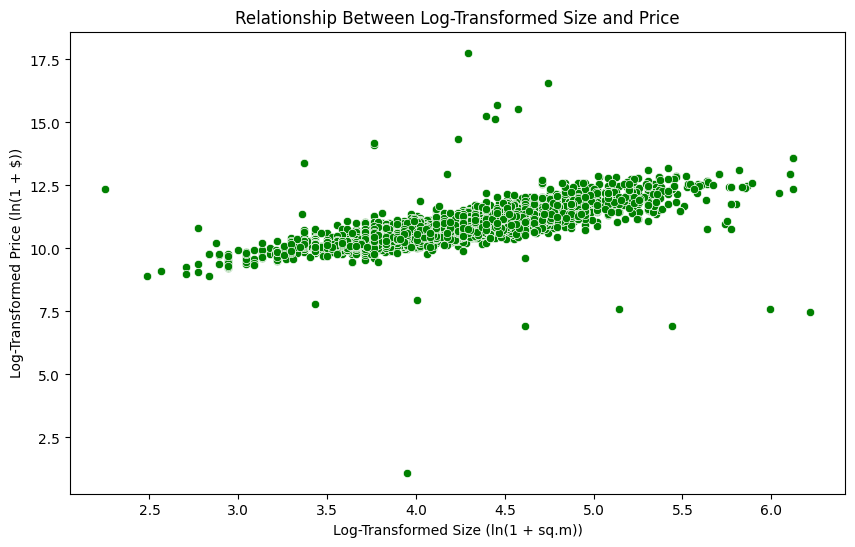

In [742]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='size', y='price',color='green')

plt.title('Relationship Between Log-Transformed Size and Price')
plt.xlabel('Log-Transformed Size (ln(1 + sq.m))')
plt.ylabel('Log-Transformed Price (ln(1 + $))')

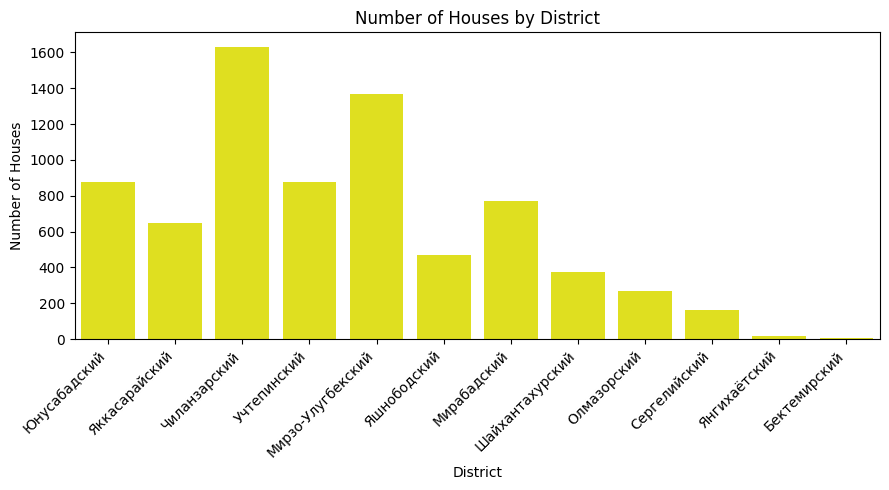

In [743]:
plt.figure(figsize=(9, 5))
sns.countplot(data=df, x='district',color='yellow')

plt.title('Number of Houses by District')
plt.xlabel('District')
plt.ylabel('Number of Houses')

# Rotate x-axis labels for better readability if district names are long
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

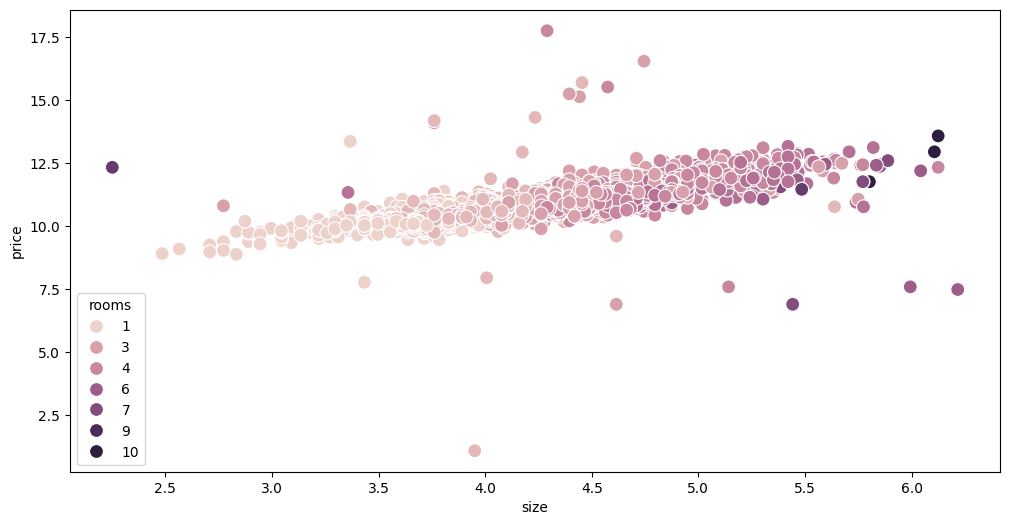

In [744]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x=df['size'], y=df['price'], hue="rooms", s=100)
plt.show()

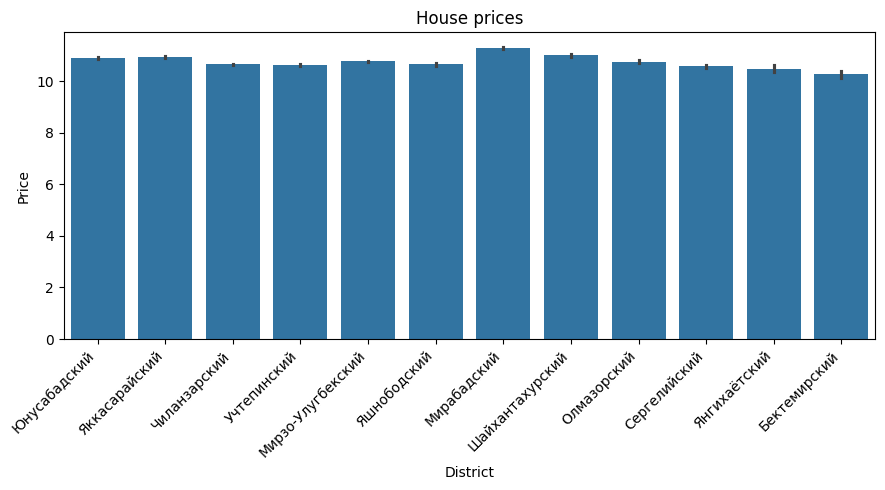

In [745]:
plt.figure(figsize=(9, 5))
sns.barplot(data=df, x='district',y='price')

plt.title('House prices')
plt.xlabel('District')
plt.ylabel('Price')

# Rotate x-axis labels for better readability if district names are long
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

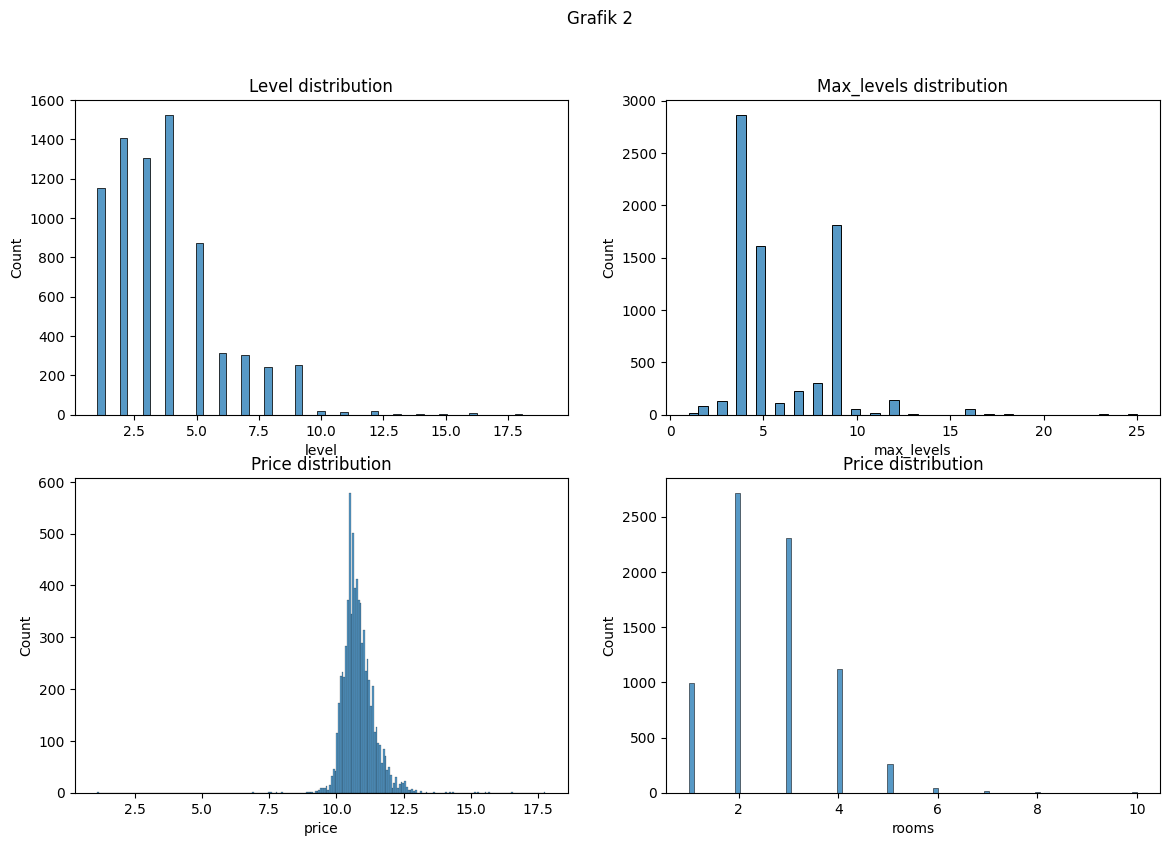

In [746]:
fig, ax = plt.subplots(2, 2, figsize=(14,9))
fig.suptitle("Grafik 2")
sns.histplot(ax=ax[0, 0], data=df, x='level')
sns.histplot(ax=ax[0, 1], data=df, x='max_levels')
sns.histplot(ax=ax[1, 0], data=df, x='price')
sns.histplot(ax=ax[1, 1], data=df, x='rooms')
# Har bir grafik uchun nom:
ax[0,0].set_title("Level distribution")
ax[0,1].set_title("Max_levels distribution")
ax[1,0].set_title("Price distribution")
ax[1,1].set_title("Price distribution")
plt.show()

In [747]:
df.corrwith(df['price'], numeric_only=True).abs().sort_values(ascending=False)

,0
price,1.000000
size,0.763311
rooms,0.632975
max_levels,0.258962
level,0.086837


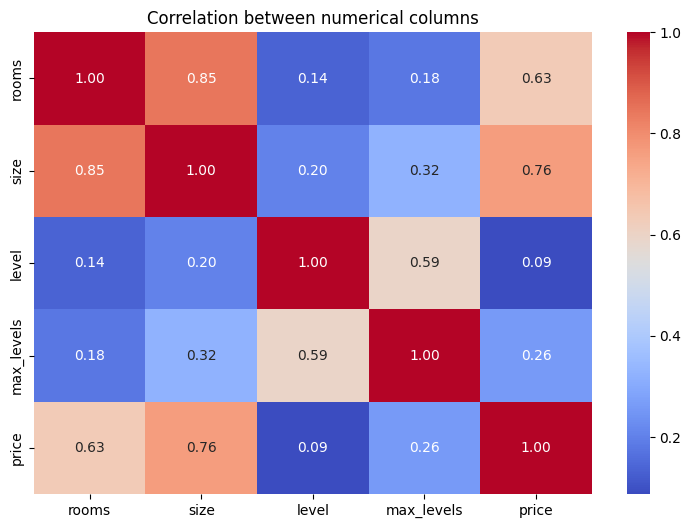

In [748]:
numeric_cols = ['rooms', 'size', 'level', 'max_levels', 'price']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(9, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between numerical columns')
plt.show()

In [749]:
# 1. rooms_per_size
df["rooms_per_size"] = df["rooms"] / df["size"]

# 2. floor_ratio
df["floor_ratio"] = df["level"] / df["max_levels"]

# 3. districtni mean price bo‘yicha kodlash
district_price_map = df.groupby("district")["price"].mean().to_dict()
df["district_mean_price"] = df["district"].map(district_price_map)

# Natijani ko‘rish
print(df.head())

        district  rooms      size  level  max_levels      price  \
0   Юнусабадский      3  4.060443      4           4  10.859018   
1  Яккасарайский      2  3.970292      4           5  10.933125   
2   Чиланзарский      2  3.761200      4           4  10.518700   
3   Чиланзарский      3  4.189655      1           4  10.809748   
4   Чиланзарский      3  4.262680      3           5  10.915107   

   rooms_per_size  floor_ratio  district_mean_price  
0        0.738836         1.00            10.899034  
1        0.503741         0.80            10.950243  
2        0.531745         1.00            10.658548  
3        0.716049         0.25            10.658548  
4        0.703783         0.60            10.658548  


**Mashine Learning**

In [750]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)


In [751]:
X_train = train_set.drop("price", axis=1)
y_train = train_set["price"].copy()
X_num = X_train.drop('district_mean_price', axis=1)

**Pipeline**

In [752]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_level_per_levels = True):
        self.add_level_per_levels = add_level_per_levels
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not all(col in X.columns for col in ['rooms', 'size', 'level', 'max_levels']):
            raise ValueError("Input DataFrame must contain 'rooms', 'size', 'level', and 'max_levels' columns")

        level_per_max_levels = X['max_levels'] / X['level']
        size_per_rooms = X['rooms'] / X['size']

        if self.add_level_per_levels:
            rooms_per_max_levels = X['max_levels'] / X['rooms']
            return np.c_[X.values, level_per_max_levels, size_per_rooms, rooms_per_max_levels]
        else:
            return np.c_[X.values, level_per_max_levels, size_per_rooms]

In [753]:
num_pipeline = Pipeline([
          ('attribs_adder', CombinedAttributesAdder(add_level_per_levels = True)),
          ('imputer', SimpleImputer(strategy='median')),
          ('std_scaler', StandardScaler())
])

In [754]:
from sklearn.compose import ColumnTransformer
num_attribs = ['rooms', 'size', 'level', 'max_levels', 'rooms_per_size', 'floor_ratio']
cat_attribs = ['district', 'district_mean_price']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [755]:
X_prepared = full_pipeline.fit_transform(X_train)

**LinearRegression**

In [756]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()

In [757]:
LR_model.fit(X_prepared, y_train)

LinearRegression()

In [758]:
test_data = X_train.sample(10)
test_data

,district,rooms,size,level,max_levels,rooms_per_size,floor_ratio,district_mean_price
6650,Мирзо-Улугбекский,4,4.753590,5,5,0.841469,1.000000,10.771805
6747,Чиланзарский,1,3.496508,3,4,0.286000,0.750000,10.658548
6595,Шайхантахурский,2,3.891820,8,9,0.513898,0.888889,11.006938
1297,Учтепинский,1,3.496508,3,4,0.286000,0.750000,10.644896
6869,Шайхантахурский,2,4.025352,4,4,0.496851,1.000000,11.006938
1554,Мирзо-Улугбекский,4,4.532599,2,5,0.882496,0.400000,10.771805
180,Чиланзарский,1,3.761200,2,5,0.265873,0.400000,10.658548
3274,Мирабадский,2,4.110874,2,4,0.486515,0.500000,11.299104
5406,Учтепинский,4,4.615121,1,9,0.866716,0.111111,10.644896
6948,Мирабадский,3,4.510860,1,9,0.665062,0.111111,11.299104


In [759]:
test_label = y_train.loc[test_data.index]
test_label

,price
6650,11.440366
6747,10.325515
6595,11.141876
1297,10.203629
6869,10.596660
1554,11.002117
180,10.257694
3274,11.034906
5406,11.385103
6948,11.350418


In [760]:
test_data_prepared = full_pipeline.transform(test_data)
test_data_prepared

array([[ 1.26680894,  1.27467128,  0.56730227, -0.40150628,  1.13962481,
         1.31717046, -0.7382559 ,  1.13962481, -0.85665936,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-1.4952878 , -1.68896897, -0.31681286, -0.78114458, -1.56314754,
         0.42726674, -0.52866414, -1.56314754,  0.76181597,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.57458889, -0.7569

In [761]:
predicted_data = LR_model.predict(test_data_prepared)
predicted_data

array([11.27920659, 10.04131644, 10.47350473,  9.95190423, 10.6151736 ,
       11.19838698, 10.37036196, 10.96534726, 11.18935389, 11.39653135])

In [762]:
pd.DataFrame({'Predicted_data':predicted_data, 'Real price': test_label})

,Predicted_data,Real price
6650,11.279207,11.440366
6747,10.041316,10.325515
6595,10.473505,11.141876
1297,9.951904,10.203629
6869,10.615174,10.596660
1554,11.198387,11.002117
180,10.370362,10.257694
3274,10.965347,11.034906
5406,11.189354,11.385103
6948,11.396531,11.350418


In [763]:
test_set

,district,rooms,size,level,max_levels,price,rooms_per_size,floor_ratio,district_mean_price
2301,Яшнободский,3,4.465908,4,9,11.396403,0.671756,0.444444,10.658563
6126,Учтепинский,3,4.262680,2,5,10.680539,0.703783,0.400000,10.644896
2149,Яккасарайский,3,4.510860,5,5,10.714440,0.665062,1.000000,10.950243
5594,Чиланзарский,1,3.610918,2,4,10.114599,0.276938,0.500000,10.658548
6566,Учтепинский,4,4.615121,1,4,11.373675,0.866716,0.250000,10.644896
...,...,...,...,...,...,...,...,...,...
6593,Шайхантахурский,3,4.394449,6,9,10.778977,0.682679,0.666667,11.006938
4089,Шайхантахурский,6,6.216606,2,2,7.496097,0.965157,1.000000,11.006938
441,Чиланзарский,1,3.610918,2,5,10.257694,0.276938,0.400000,10.658548
5639,Шайхантахурский,3,4.262680,6,7,11.002117,0.703783,0.857143,11.006938


In [764]:
X_test = test_set.drop('price',axis=1)

In [765]:
y_test = test_set['price'].copy()
y_test

,price
2301,11.396403
6126,10.680539
2149,10.714440
5594,10.114599
6566,11.373675
...,...
6593,10.778977
4089,7.496097
441,10.257694
5639,11.002117


In [766]:
X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared

array([[ 0.34611002,  0.59644525,  0.12524471, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34611002,  0.11732368, -0.75887042, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34611002,  0.70242057,  0.56730227, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.4952878 , -1.41924038, -0.75887042, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34611002,  0.11732368,  1.00935984, ...,  0.        ,
         1.        ,  0.        ],
       [-0.57458889, -0.75699782, -0.31681286, ...,  0.        ,
         0.        ,  1.        ]])

In [767]:
y_predicted = LR_model.predict(X_test_prepared)

In [768]:
lin_mse = mean_squared_error(y_test, y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

0.487716656894255


**DecisionTree**

In [769]:
from sklearn.tree import DecisionTreeRegressor
Tree_model = DecisionTreeRegressor()
Tree_model.fit(X_prepared, y_train)

DecisionTreeRegressor()

In [770]:
y_predicted = Tree_model.predict(X_test_prepared)

In [771]:
lin_mse = mean_squared_error(y_test, y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

0.4943981418089456


**RandomForest**

In [772]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor()
RF_model.fit(X_prepared, y_train)

RandomForestRegressor()

In [773]:
y_predicted = RF_model.predict(X_test_prepared)
lin_mse = mean_squared_error(y_test, y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

0.45013676205905134


**XGBoost Regressor**

In [774]:
xgb_model = XGBRegressor()
xgb_model.fit(full_pipeline.transform(X_train), y_train)

# Model evaluation
y_predicted = xgb_model.predict(X_test_prepared)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
print("XGBoost RMSE:", xgb_rmse)

XGBoost RMSE: 0.44887786106106


In [775]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=200, random_state=42)
scores = cross_val_score(xgb_model, full_pipeline.transform(X_train), y_train,
                         scoring="r2", cv=10)
print("R² mean:", scores.mean())


R² mean: 0.7239497668447203


In [776]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,
                           scoring="r2", verbose=2, n_jobs=-1)

grid_search.fit(full_pipeline.transform(X_train), y_train)

print("Best_params:", grid_search.best_params_)
print("R²:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best_params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
R²: 0.7246773750778092


**Cross-Validation**

In [777]:
X = df.drop("price", axis=1)
y = df["price"].copy()

X_prepared = full_pipeline.transform(X)

In [778]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std.dev:", scores.std())

In [779]:
from sklearn.model_selection import cross_val_score

***LinearRegression***

In [780]:
scores = cross_val_score(LR_model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
LR_rmse_scores = np.sqrt(-scores)

In [781]:
display_scores(LR_rmse_scores)

Scores: [0.32328991 0.22665205 0.40630087 0.29065724 0.27886485 0.3837594
 0.30731075 0.39882966 0.32266139 0.56898857]
Mean: 0.35073146830357443
Std.dev: 0.09040141395110421


In [782]:
scores = cross_val_score(LR_model, X_prepared, y, scoring="r2", cv=10)
display_scores(scores)

Scores: [0.65288969 0.75274968 0.59137294 0.71702891 0.76485191 0.56309383
 0.71144709 0.5718676  0.64993785 0.34102048]
Mean: 0.6316259990953571
Std.dev: 0.11883274788017258


***DecisionTree***

In [783]:
scores = cross_val_score(Tree_model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
Tree_rmse_scores = np.sqrt(-scores)
display_scores(Tree_rmse_scores)

Scores: [0.40003739 0.40433503 0.390045   0.45099202 0.30017561 0.52274991
 0.32038711 0.44734109 0.39073584 0.56726761]
Mean: 0.4194066629112291
Std.dev: 0.07786399428785361


In [784]:
scores = cross_val_score(Tree_model, X_prepared, y, scoring="r2", cv=10)
display_scores(scores)

Scores: [0.53644941 0.2038494  0.62155888 0.44999173 0.72418097 0.19270896
 0.6072212  0.52217806 0.47901787 0.37071199]
Mean: 0.47078684668300835
Std.dev: 0.16480467973821253


***RandomForest***

In [785]:
scores = cross_val_score(RF_model, X_prepared, y, scoring="neg_mean_squared_error", cv=10)
Rd_rmse_scores = np.sqrt(-scores)
display_scores(Rd_rmse_scores)

Scores: [0.30083957 0.25469301 0.34451248 0.28869484 0.27615794 0.38270974
 0.27990515 0.38098637 0.31038872 0.537514  ]
Mean: 0.3356401814882232
Std.dev: 0.07896400174319519


In [786]:
scores = cross_val_score(RF_model, X_prepared, y, scoring="r2", cv=10)
display_scores(scores)

Scores: [0.70119244 0.65247818 0.70725119 0.71265088 0.77263938 0.56569663
 0.75788901 0.60729907 0.67644646 0.40418641]
Mean: 0.6557729651552539
Std.dev: 0.10306841802707566


***XGBoost Regressor***

In [790]:
xgb_reg = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_scores = cross_val_score(
    xgb_reg, full_pipeline.transform(X_train), y_train,
    scoring="neg_mean_squared_error", cv=10
)
xgb_rmse_scores = np.sqrt(-xgb_scores)

display_scores(xgb_rmse_scores)

Scores: [0.23510595 0.32232698 0.22537699 0.35567635 0.24701908 0.30510711
 0.29127709 0.32516391 0.31803674 0.25055697]
Mean: 0.28756471693675184
Std.dev: 0.04259592367008943
